In [8]:
from sys import path as syspath
from pathlib import Path
import numpy as np

syspath.append(str(Path().home() / "pyref" / "src"))

import pyref as rf
from pyref.style import science
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from pypxr.structure import *
from pypxr.reflectivity import *
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from refnx._lib.emcee.moves.de import *
from pyref.fitting.logp import LogpExtra_rough


db = rf.db()

In [9]:
import scienceplots

plt.style.use("default")
plt.style.use(["science", "no-latex"])

In [10]:
znpc_ocs = db.get_oc("C32H16N8Zn")

en_range = np.linspace(274, 295, 1000)

delta_xx = znpc_ocs.xx(en_range)
delta_zz = znpc_ocs.zz(en_range)
delta_iso = znpc_ocs.delta(en_range)

beta_xx = znpc_ocs.ixx(en_range)
beta_zz = znpc_ocs.izz(en_range)
beta_iso = znpc_ocs.beta(en_range)

[]

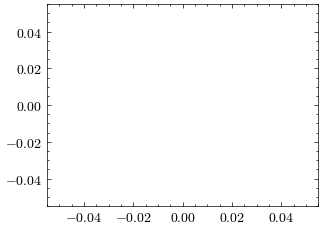

In [11]:
plt.plot()

In [12]:
znpc_mono = {
    "250": {
        "s": db.get_refl("zrt_250.0_100.csv", "ZnPc"),
        "p": db.get_refl("zrt_250.0_190.csv", "ZnPc"),
        },
    "275": {
        "s": db.get_refl("275.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("275.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "280": {
        "s": db.get_refl("280.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("280.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "281": {
        "s": db.get_refl("281.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("281.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "282": {
        "s": db.get_refl("282.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("282.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "282.3": {
        "s": db.get_refl("282.3_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("282.3_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "282.7": {
        "s": db.get_refl("282.7_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("282.7_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "283.1": {
        "s": db.get_refl("283.1_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("283.1_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "283.7": {
        "s": db.get_refl("ZnPc_283.7_100.0 (CCD Scan 82865).parquet", "ZnPc"),
        "p": db.get_refl("ZnPc_283.7_190.0 (CCD Scan 82869).parquet", "ZnPc"),
    },
    "284.0": {
        "s": db.get_refl("ZnPc_284.0_100.0 (CCD Scan 82865).parquet", "ZnPc"),
        "p": db.get_refl("ZnPc_284.0_190.0 (CCD Scan 82869).parquet", "ZnPc"),
        },
    "284.2": {
        "s": db.get_refl("ZnPc_284.2_100.0_refl (CCD Scan 82867).parquet", "ZnPc"),
        "p": db.get_refl("ZnPc_284.2_190.0_refl (CCD Scan 82872).parquet", "ZnPc"),
    },
    "287.0": {
        "s": db.get_refl("ZnPc_287.0_100.0_refl (CCD Scan 82259).parquet", "ZnPc"),
        "p": db.get_refl("ZnPc_287.0_190.0_refl (CCD Scan 82261).parquet", "ZnPc"),
    },
    "289.0": {
        "s": db.get_refl("ZnPc_289.0_100.0_refl (CCD Scan 82259).parquet", "ZnPc"),
        "p": db.get_refl("ZnPc_289.0_190.0_refl (CCD Scan 82261).parquet", "ZnPc"),
    }
}

In [13]:
import pandas as pd
dft_exp = pd.read_csv("DFT_MagicAngle.txt")
all_params = pd.read_csv("allParamsSorted.txt", skiprows=1,
                         names=["Transition Energy (eV)", "Transition Amplitude (a.u.)", "Transition Width (eV)",
                                "TDM_x", "TDM_y", "TDM_z", "TDM Theta (degrees)", "Transition Symmetry",
                                "TDM_xx", "TDM_yy", "TDM_zz", "TDM_xy", "TDM_xz", "TDM_yz", "Originating atom",
                                "Originating MO", "Cluster"])
clusters_params = pd.read_csv("Clustered.txt", skiprows=1,
                         names=["Transition Energy (eV)", "Transition Amplitude (a.u.)", "Transition Width (eV)",
                                "TDM_x", "TDM_y", "TDM_z", "TDM Theta (degrees)", "Transition Symmetry",
                                "TDM_xx", "TDM_yy", "TDM_zz", "TDM_xy", "TDM_xz", "TDM_yz", "Originating atom",
                                "Originating MO", "Cluster"])

dft = dft_exp[["eV_","TotalSpec_NEXAFS"]].copy()
exp = dft_exp[["E_55","ZnPc_55"]].copy().dropna()

dft_ps = dft["eV_"].loc[dft["TotalSpec_NEXAFS"] == dft["TotalSpec_NEXAFS"].max()].values[0]
exp_ps = exp["E_55"].loc[exp["ZnPc_55"] == exp["ZnPc_55"].max()].values[0]

energy_shift = dft_ps - exp_ps
dft["eV_"] -= energy_shift

def get_scale():
    en = 320
    stitch_loc = exp.iloc[(exp["E_55"] - en).abs().argsort()[0]]
    _scale = dft["TotalSpec_NEXAFS"].loc[dft["eV_"].round(2) == en].values / stitch_loc["ZnPc_55"]
    return _scale

dft["TotalSpec_NEXAFS"] /= get_scale()
dft["TotalSpec_NEXAFS"] -= dft["TotalSpec_NEXAFS"].loc[dft["eV_"] >= 282].min()
exp["ZnPc_55"] -= exp["ZnPc_55"].loc[exp["E_55"] >= 282].min()

In [14]:
display(all_params.head())
display(clusters_params)
scale = 0.001113*60/0.017448

,Transition Energy (eV),Transition Amplitude (a.u.),Transition Width (eV),TDM_x,TDM_y,TDM_z,TDM Theta (degrees),Transition Symmetry,TDM_xx,TDM_yy,TDM_zz,TDM_xy,TDM_xz,TDM_yz,Originating atom,Originating MO,Cluster
0,283.71094,0.002573,0.212314,0.007478,0.007478,0.999944,0.605872,1,1.439090e-07,1.439090e-07,0.002573,0,0,0,4,117,0
1,283.72656,0.002346,0.212314,0.007806,0.007806,0.999939,0.632420,1,1.429202e-07,1.429202e-07,0.002345,0,0,0,3,117,0
2,283.82031,0.001113,0.212314,0.008591,0.008591,0.999926,0.696050,1,8.213485e-08,8.213485e-08,0.001113,0,0,0,2,117,0
3,283.88165,0.000459,0.212314,0.007709,0.007709,0.999941,0.624637,1,2.726191e-08,2.726191e-08,0.000459,0,0,0,3,118,0
4,283.88425,0.000124,0.212314,0.006909,0.006909,0.999952,0.559881,1,5.938606e-09,5.938606e-09,0.000124,0,0,0,4,118,0


,Transition Energy (eV),Transition Amplitude (a.u.),Transition Width (eV),TDM_x,TDM_y,TDM_z,TDM Theta (degrees),Transition Symmetry,TDM_xx,TDM_yy,TDM_zz,TDM_xy,TDM_xz,TDM_yz,Originating atom,Originating MO,Cluster
0,283.80191,0.017448,0.236435,0.039977,0.039977,4.999680,0.004993,1,5.868812e-07,5.868812e-07,0.009524,0,0,0,1,117,NaN
1,284.68234,0.048513,0.223871,0.022457,0.022457,2.999832,0.004530,1,1.510299e-06,1.510299e-06,0.027013,0,0,0,2,119,NaN
2,285.20261,0.014443,0.225601,0.030391,0.030391,3.999769,0.004443,1,4.587944e-07,4.587944e-07,0.008367,0,0,0,1,119,NaN
3,286.24313,0.023100,0.213482,0.015321,0.015321,1.999883,0.004756,1,6.557800e-07,6.557800e-07,0.011173,0,0,0,4,124,NaN
4,286.72336,0.013969,0.215778,1.420645,1.420645,1.015793,16.764746,1,8.595939e-04,8.595939e-04,0.004035,0,0,0,1,124,NaN
5,287.64383,0.013186,0.213177,0.007755,0.007755,0.999940,0.004873,1,6.734356e-08,6.734356e-08,0.001120,0,0,0,2,133,NaN
6,289.16458,0.015488,0.292297,0.012963,0.012963,1.999914,0.003323,1,8.940416e-08,8.940416e-08,0.002180,0,0,0,2,171,NaN
7,290.16507,0.020387,0.454604,0.052309,0.052309,6.999338,0.008111,1,1.530749e-06,1.530749e-06,0.015291,0,0,0,2,191,NaN
8,291.64581,0.024999,0.728375,10.605230,10.605230,0.185568,89.981560,1,1.031344e-02,1.031344e-02,0.000005,0,0,0,1,209,NaN
9,293.56677,0.023640,1.149679,6.427237,6.427237,3.148559,48.915871,1,4.667293e-03,4.667293e-03,0.005755,0,0,0,3,249,NaN


In [15]:
from scipy.interpolate import interp1d
def rmsd(x, y):
    return np.sqrt(np.mean((x - y)**2))

def percent_diff(x,y):
    return (x-y)/((x+y)/2)*100


exp = exp[exp["E_55"] >= 282][exp["E_55"] <= 320].copy()
# calculate the interpolated rmsd between exp and dft
dft_interp = interp1d(dft["eV_"], dft["TotalSpec_NEXAFS"], kind="cubic")(exp["E_55"])
rmsd_dft = rmsd(dft_interp, exp["ZnPc_55"])
resid_dft = percent_diff(exp["ZnPc_55"], dft_interp)

C:\Users\hduva\AppData\Local\Temp\ipykernel_52216\1348758796.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exp = exp[exp["E_55"] >= 282][exp["E_55"] <= 320].copy()


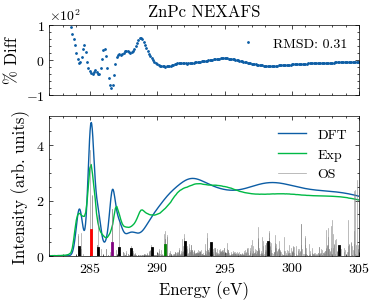

In [16]:
fig, ax = plt.subplots(figsize = (4,3), nrows=2, sharex=True, gridspec_kw={"height_ratios": [1, 2]})

dft.plot(x="eV_", y="TotalSpec_NEXAFS", ax=ax[1], label="DFT")
exp.plot(x="E_55", y="ZnPc_55", ax=ax[1], label="Exp")

ax[0].plot(exp["E_55"], resid_dft, label=f"RMSD: {rmsd_dft:.2f}", marker='o', ls="", markersize = 1)
ax[0].legend(loc = "upper right")
ax[0].set_ylim(-100, 100)
ax[0].set_ylabel("% Diff", fontweight="bold", fontsize=12)

ax[0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

for tdm, os in zip(all_params["Transition Energy (eV)"], all_params["Transition Amplitude (a.u.)"]):
    ax[1].axvline(x=tdm - energy_shift, ymax=os*60, color="grey", linestyle="-", linewidth=0.5, alpha=.75)


c = ["k", "r", "k", "purple", "k", "k", "k", "green", "k", "k", "k", "k", "k"]

for i, (tdm, os) in enumerate(zip(clusters_params["Transition Energy (eV)"], clusters_params["Transition Amplitude (a.u.)"])):
    ax[1].axvline(x=tdm - energy_shift, ymax=os*scale, color=c[i], linestyle="-", linewidth=2)

ax[1].legend(["DFT", "Exp", "OS"], loc="upper right")
ax[1].set_ylim(bottom=0)
ax[1].set_xlim(282, 305)
ax[1].set_xlabel("Energy (eV)", fontweight="bold", fontsize=12)
ax[1].set_ylabel("Intensity (arb. units)", fontweight="bold", fontsize=12)
ax[0].set_title("ZnPc NEXAFS", fontweight="bold", fontsize=12)
fig.savefig("Result.svg", bbox_inches = "tight", dpi = 300, facecolor = "white")

In [17]:
clusters_params.iloc[[0, 1,3,7]]

,Transition Energy (eV),Transition Amplitude (a.u.),Transition Width (eV),TDM_x,TDM_y,TDM_z,TDM Theta (degrees),Transition Symmetry,TDM_xx,TDM_yy,TDM_zz,TDM_xy,TDM_xz,TDM_yz,Originating atom,Originating MO,Cluster
0,283.80191,0.017448,0.236435,0.039977,0.039977,4.999680,0.004993,1,5.868812e-07,5.868812e-07,0.009524,0,0,0,1,117,NaN
1,284.68234,0.048513,0.223871,0.022457,0.022457,2.999832,0.004530,1,1.510299e-06,1.510299e-06,0.027013,0,0,0,2,119,NaN
3,286.24313,0.023100,0.213482,0.015321,0.015321,1.999883,0.004756,1,6.557800e-07,6.557800e-07,0.011173,0,0,0,4,124,NaN
7,290.16507,0.020387,0.454604,0.052309,0.052309,6.999338,0.008111,1,1.530749e-06,1.530749e-06,0.015291,0,0,0,2,191,NaN


In [56]:
from scipy.signal import find_peaks
from matplotlib.animation import FuncAnimation

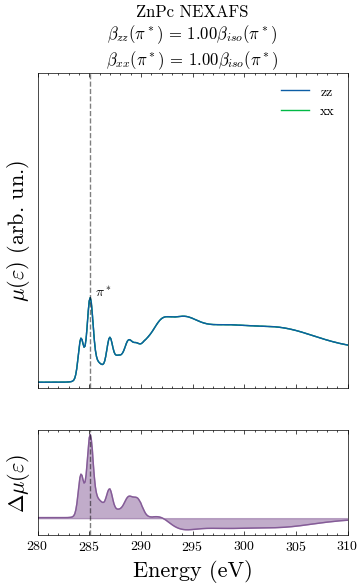

In [108]:
shift = 1e3

fig, ax = plt.subplots(nrows = 2, figsize=(4, 6), edgecolor="white", facecolor="white", gridspec_kw={"height_ratios": [3, 1]}, sharex=True)

full_exp["Diff"] = full_exp["90"]-full_exp["20"]

ax[0].plot(full_exp["Energy [eV]"], full_exp["55"], zorder=2)
ax[0].plot(full_exp["Energy [eV]"], full_exp["55"], zorder=1)

ax[0].plot(full_exp["Energy [eV]"], full_exp["55"], c = "grey", alpha = .5, linestyle="--", zorder=0)


ax[1].plot(full_exp["Energy [eV]"], full_exp["Diff"], c="C4")
ax[1].fill_between(full_exp["Energy [eV]"], full_exp["Diff"], y2=-shift, alpha=0.5, color="C4")

ax[0].grid(False)
ax[1].grid(False)

pi_energy = find_peaks(full_exp["90"], height=1e4)[0][1]

ax[0].axvline(full_exp["Energy [eV]"].iloc[pi_energy], color="k", linestyle="--", alpha=0.5)
ax[1].axvline(full_exp["Energy [eV]"].iloc[pi_energy], color="k", linestyle="--", alpha=0.5)

int_90 = full_exp["90"].iloc[pi_energy]
int_55 = full_exp["55"].iloc[pi_energy]
int_ds = full_exp["Diff"].iloc[pi_energy]

zsf = 2 * int_55 / int_ds
xsf = (int_55 - full_exp["55"].iloc[0]) / int_ds

z_scales = np.linspace(0, zsf, 200)
x_scales = np.linspace(0, xsf, 200)

ax[0].set_yticks([])
ax[0].set_ylabel(r"$\mu (\varepsilon)$ (arb. un.)", fontsize=16)
ax[0].tick_params(axis="x", bottom=True, which="both")
ax[0].set_xlim(280, 310)
ax[0].legend(["zz", "xx"], loc="upper right")
ax[0].annotate(r"$\pi^*$", (full_exp["Energy [eV]"].iloc[pi_energy], int_55), xytext=(full_exp["Energy [eV]"].iloc[pi_energy]+0.5, int_55+1e3))

ax[1].set_yticks([])
ax[1].set_ylabel(r"$\Delta \mu (\varepsilon)$", fontsize=16)
ax[1].set_xlabel(r"Energy (eV)", fontsize=16)
ax[0].set_ylim(0, 3.5*int_55)

def update(frame):
    z_scale = z_scales[frame]
    x_scale = x_scales[frame]

    zz = full_exp["55"] + z_scale * full_exp["Diff"]
    xx = full_exp["55"] - x_scale * full_exp["Diff"]

    ax[0].lines[0].set_ydata(zz)
    ax[0].lines[1].set_ydata(xx)
    ratio_z = zz.iloc[pi_energy] / int_55
    ratio_x = xx.iloc[pi_energy] / int_55

    ax[0].set_title("ZnPc NEXAFS\n"+
                    r"$\beta_{zz}(\pi^*)$ = "+f"{ratio_z:.2f}" + r"$\beta_{iso}(\pi^*)$" +"\n"+
                    r"$\beta_{xx}(\pi^*)$ = "+f"{ratio_x:.2f}" + r"$\beta_{iso}(\pi^*)$", fontsize=12)

ani = FuncAnimation(fig, update, frames=200, interval=5, repeat=False)
ani.save("ZnPc_NEXAFS.mp4", fps = 60, dpi=300)

In [47]:
# Load the models
energies = [250, 275, 280, 281, 282, 282.3, 282.7, 283.1, 283.7, 284.0, 284.2, 287.0, 289.0]
models = {}.fromkeys(energies)
oocs = {}.fromkeys(energies)

from pypxr.structure import *
from pypxr.reflectivity import *
from pyref.fitting import from_json
import pickle as pkl
import json

# extract structure params, insturment settings, and optical parameters from each saved json file
short = [275, 280, 281, 282, 282.3, 282.7, 283.1]
for i, en in enumerate(short):
    if (db.res / f"{float(en)}_model.csv").exists():
        sp = pd.read_csv(db.res / f"{float(en)}_model.csv")
        models[en] = sp
    else:
        pass
long = [283.7, 284.0, 284.2, 287.0, 289.0]
for i, en in enumerate(long):
    if (db.res / f"{float(en)}_model_Struc1.csv").exists():
        sp = pd.read_csv(db.res / f"{float(en)}_model_Struc1.csv")
        models[en] = sp
    else:
        pass

s = np.loadtxt(db.res / "ZnPc_250eV_s_fit.txt", delimiter=",").T
p = np.loadtxt(db.res / "ZnPc_250eV_p_fit.txt", delimiter=",").T

models[250] = {"s": s, "p": p}
display(models[275])

,Q,Refl_s,Refl_p
0,0.005000,0.715873,0.796802
1,0.005065,0.714617,0.795390
2,0.005130,0.713359,0.793975
3,0.005195,0.712099,0.792558
4,0.005260,0.710836,0.791139
...,...,...,...
995,0.069740,0.001942,0.001737
996,0.069805,0.001925,0.001723
997,0.069870,0.001909,0.001708
998,0.069935,0.001893,0.001694


,xx,zz,dxx,dzz,delta,ddelta,ixx,izz,dixx,dizz,beta,dbeta,energy,dxx_99,dzz_99,dixx_99,dizz_99
0,-0.001676,-0.000637,0.000052,0.000061,-0.000571,NaN,0.000842,0.000800,3.368173e-05,3.654878e-05,0.000547,NaN,283.7,0.000105,0.000121,6.736346e-05,7.309756e-05
1,-0.002139,-0.000802,0.000071,0.000035,-0.001077,NaN,0.001387,0.000971,2.692043e-05,3.036869e-05,0.001000,NaN,284.0,0.000143,0.000069,5.384086e-05,6.073737e-05
2,-0.002350,-0.000094,0.000028,0.000014,-0.001077,NaN,0.001990,0.001129,2.170199e-05,2.574922e-05,0.001000,NaN,284.2,0.000057,0.000028,4.340398e-05,5.149844e-05
3,-0.000371,-0.000373,0.000007,0.000003,-0.001077,NaN,0.003711,0.003902,8.709596e-05,9.976825e-05,0.001000,NaN,287.0,0.000014,0.000007,1.741919e-04,1.995365e-04
4,-0.000351,0.000040,0.000004,0.000036,0.000319,NaN,0.002345,0.002705,2.930466e-05,3.624521e-05,0.001866,NaN,289.0,0.000007,0.000072,5.860933e-05,7.249041e-05
0,0.001153,0.001163,0.000013,0.000003,0.000939,NaN,0.000201,0.000201,0.000000e+00,0.000000e+00,0.000201,NaN,275.0,0.000026,0.000006,0.000000e+00,0.000000e+00
1,0.000727,0.000858,0.000051,0.000016,0.000329,NaN,0.000197,0.000197,2.181875e-10,2.224330e-10,0.000197,NaN,280.0,0.000102,0.000032,4.363750e-10,4.448661e-10
2,0.000428,0.000772,0.000031,0.000013,0.000081,NaN,0.000198,0.000198,6.298336e-07,6.415796e-07,0.000197,NaN,281.0,0.000062,0.000026,1.259667e-06,1.283159e-06
3,0.000149,0.000641,0.000030,0.000029,-0.000303,NaN,0.000199,0.000200,1.425224e-06,1.470028e-06,0.000198,NaN,282.0,0.000060,0.000058,2.850448e-06,2.940056e-06
4,0.000032,0.000615,0.000007,0.000024,-0.000469,NaN,0.000200,0.000200,1.555467e-06,1.578348e-06,0.000199,NaN,282.3,0.000013,0.000049,3.110933e-06,3.156697e-06


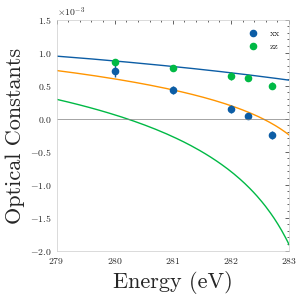

In [106]:
# load fit results
import pandas as pd
low_res = pd.read_csv(db.res / "ZnPc_OC.csv")
low_res = low_res[low_res["energy"] < 283.7]
fit_res = pd.read_csv(db.res / "Struc1_ocs.csv", index_col=0)
fit_res = pd.concat([fit_res, low_res])
fit_res["dxx_99"] = fit_res["dxx"] * 2
fit_res["dzz_99"] = fit_res["dzz"] * 2
fit_res["dixx_99"] = fit_res["dixx"] * 2
fit_res["dizz_99"] = fit_res["dizz"] * 2
fit_res.loc[fit_res["energy"] == 284.1, "energy"] = 284.0

fig, ax = plt.subplots(1, 1, figsize=(3,3))
display(fit_res)
ax.plot(en_range, delta_xx, label = r"$\delta_{xx}$", zorder=1)
ax.plot(en_range, delta_zz, label = r"$\delta_{zz}$", zorder=1)
ax.plot(en_range, delta_iso, label = r"$\delta_{iso}$", zorder=1)

fit_res.plot(x = "energy", y = "xx", yerr = "dxx_99", kind = "scatter", ax = ax, color = "C0",edgecolor = "C0", label = "xx", zorder=2)
fit_res.plot(x = "energy", y = "zz", yerr = "dzz_99", kind = "scatter", ax = ax, color="C1", edgecolor = "C1", label = "zz", zorder=2)
ax.set_xlim(279, 283)
ax.set_ylim(-2e-3, 1.5e-3)
ax.grid(False)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.set_xlabel("Energy (eV)", fontsize=16)
ax.set_ylabel("Optical Constants", fontsize=16)
ax.axhline(0, color="grey",linewidth=0.5)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

fig.savefig("DeltaCross.svg", bbox_inches = "tight", dpi = 300, facecolor = "white")

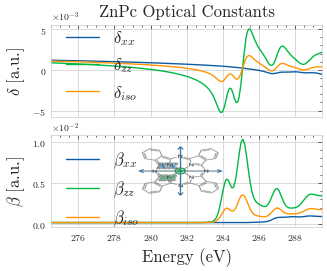

In [49]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(3.5, 2.625))

_img = "ZnPc_Diagram.png"
data = plt.imread(_img)
x1, x2, y1, y2 = 276, 284,.1e-2, .6e-2
insax = ax[1].inset_axes([0.3, 0.3, 0.35, 0.6], xticks = [], yticks = [], frame_on = False)
insax.imshow(data, aspect="auto")

ax[0].plot(en_range, delta_xx, label = r"$\delta_{xx}$", zorder=1)
ax[0].plot(en_range, delta_zz, label = r"$\delta_{zz}$", zorder=1)
ax[0].plot(en_range, delta_iso, label = r"$\delta_{iso}$", zorder=1)
ax[0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax[0].legend(fontsize=12, loc="lower left")

ax[1].plot(en_range, beta_xx, label = r"$\beta_{xx}$", zorder=1)
ax[1].plot(en_range, beta_zz, label = r"$\beta_{zz}$", zorder=1)
ax[1].plot(en_range, beta_iso, label = r"$\beta_{iso}$", zorder=1)
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax[0].set_ylabel(r"$\delta$ [a.u.]", fontweight="bold", fontsize=12)
ax[1].set_ylabel(r"$\beta$ [a.u.]", fontweight="bold", fontsize=12)
ax[1].set_xlabel("Energy (eV)", fontweight="bold", fontsize=12)
ax[1].set_xlim(274.5, 289.5)
ax[0].set_title("ZnPc Optical Constants", fontweight="bold", fontsize=12)
ax[1].legend(fontsize=12, loc="upper left")
fig.savefig("OC.svg", bbox_inches = "tight", dpi = 300, facecolor = "white")

C:\Users\hduva\AppData\Local\Temp\ipykernel_23536\3262983942.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s["Refl"] = s["Refl"] * scales[i]
C:\Users\hduva\AppData\Local\Temp\ipykernel_23536\3262983942.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s["Refl"] = s["Refl"] * scales[i]
C:\Users\hduva\AppData\Local\Temp\ipykernel_23536\3262983942.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


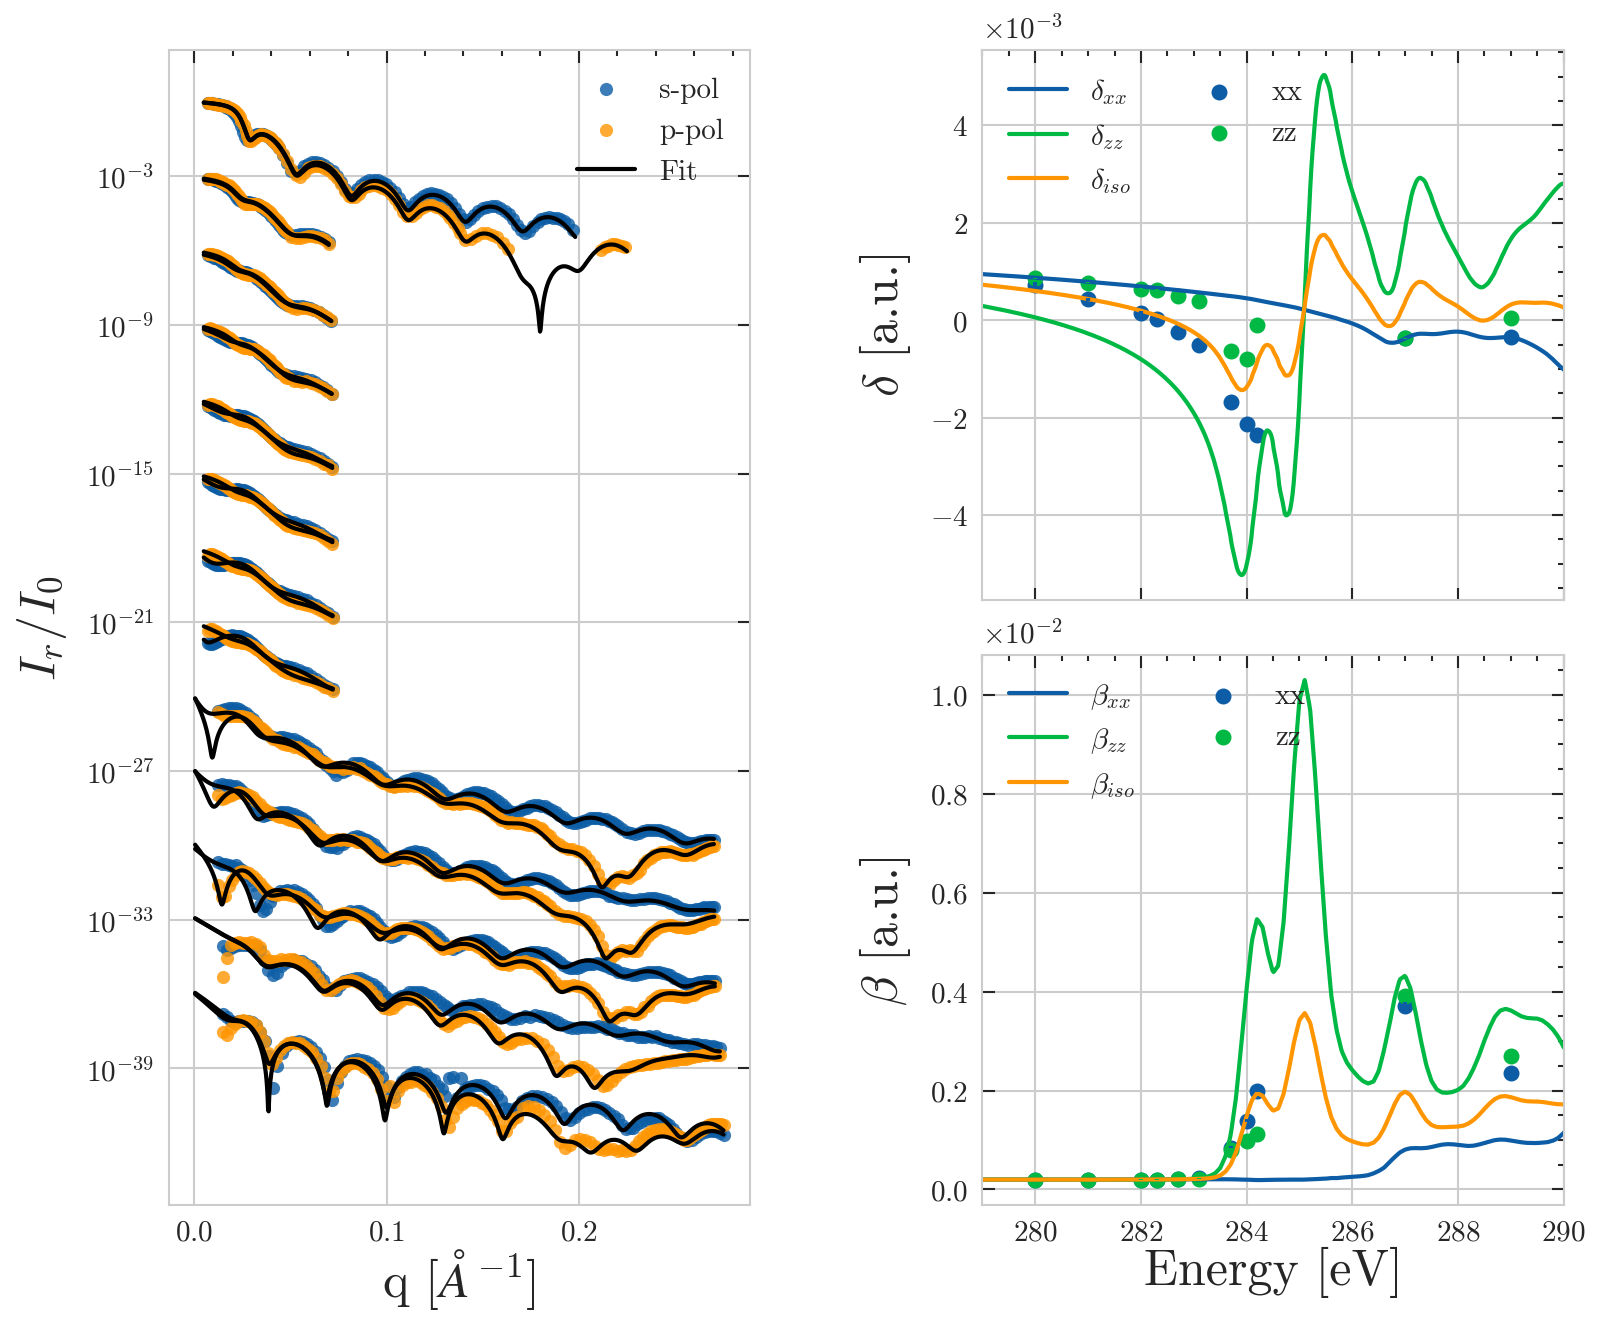

In [109]:

import matplotlib.transforms as mtransforms

legend_prop = {}

fig, ax = plt.subplot_mosaic(
    [["refl", "delta"],
     ["refl", "beta"]],
    gridspec_kw = {"wspace": 0.4, "hspace": 0.1},
    figsize = (6, 5),
    dpi=300,
)
fig.align_ylabels()

trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)

ax["delta"].plot(en_range, delta_xx, label = r"$\delta_{xx}$", linewidth = 1)
ax["delta"].plot(en_range, delta_zz, label = r"$\delta_{zz}$", linewidth = 1)
ax["delta"].plot(en_range, delta_iso, label = r"$\delta_{iso}$", linewidth = 1)

fit_res.plot(x = "energy", y = "xx", yerr = "dxx", kind = "scatter", ax = ax["delta"], color = "C0", s = 8, label = "xx")
fit_res.plot(x = "energy", y = "zz", yerr = "dzz", kind = "scatter", ax = ax["delta"], color = "C1", s = 8, label = "zz")



plt.sca(ax["delta"])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)

ax["beta"].plot(en_range, beta_xx, label = r"$\beta_{xx}$", linewidth = 1)
ax["beta"].plot(en_range, beta_zz, label = r"$\beta_{zz}$", linewidth = 1 )
ax["beta"].plot(en_range, beta_iso, label = r"$\beta_{iso}$", linewidth = 1)
fit_res.plot(x = "energy", y = "ixx", yerr = "dixx", kind = "scatter", ax = ax["beta"], color = "C0", s = 8, label = "xx")
fit_res.plot(x = "energy", y = "izz", yerr = "dizz", kind = "scatter", ax = ax["beta"], color = "C1", s = 8, label = "zz")

ax["delta"].set_xlabel("Energy [eV]", labelpad = 0, fontsize = 12, fontweight = "bold")
ax["delta"].set_ylabel(r"$\delta$ [a.u.]", fontsize = 12, fontweight = "bold")
ax["beta"].set_ylabel(r"$\beta$ [a.u.]", fontsize = 12, fontweight = "bold")
ax["beta"].set_xlabel("Energy [eV]", labelpad = 0, fontsize = 12, fontweight = "bold")
ax["beta"].set_xlim(279, 290)
ax["delta"].set_xlim(279, 290)

ax["delta"].legend(loc = "upper left", ncols = 2)

plt.sca(ax["beta"])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)

ax["beta"].sharex(ax["delta"])
ax["beta"].legend(loc="upper left", ncol = 2)
ax["delta"].tick_params(labelbottom = False)

ax["delta"].tick_params(axis="x", bottom=True)
ax["beta"].tick_params(axis="y", left=True)


_scales = {
    "250" : 1,
    "long": 1e-3,
}

es = [250, 275, 280, 281, 282, 282.3, 282.7, 283.1, 283.7, 284.0, 284.2, 287.0, 289.0]

scales = []
for i,en in enumerate(es):
    if i == 0:
        scale = _scales["250"]
    else:
        scale = _scales["long"] * scales[-1]
    scales.append(scale)

q_range = np.linspace(0.001, 0.3, 1000)


for i, en in enumerate(es):
    s = znpc_mono[f"{en}"]["s"].iloc[6:]
    p = znpc_mono[f"{en}"]["p"].iloc[6:]


    if en == 250:
        # in p where Refl < 1e-6
        p = p[p["Refl"] > 1e-6]

    s["Refl"] = s["Refl"] * scales[i]
    p["Refl"] = p["Refl"] * scales[i]

    # scale data frames to have a 1 order of magnitude offset

    s.plot(x = "Q", y = "Refl", ax = ax["refl"], kind = 'scatter', s = 10, color = "C0", alpha=.8, linewidth=0)
    p.plot(x = "Q", y = "Refl", ax = ax["refl"], kind = 'scatter', s = 10, color = "C2", alpha=.8, linewidth=0)

    if True:
        if en != 250:
            sns.lineplot(x=models[en]["Q"], y=models[en]["Refl_s"]*scales[i], ax = ax["refl"], color = "k", linewidth = 1)
            sns.lineplot(x=models[en]["Q"], y=models[en]["Refl_p"]*scales[i], ax = ax["refl"], color = "k", linewidth = 1)
            continue

        q_s = models[en]["s"][:,0][q_range <= s.iloc[-1]["Q"]]
        q_p = models[en]["p"][:,0][q_range <= p.iloc[-1]["Q"]]
        s_model = models[en]["s"][:,1][q_range < s.iloc[-1]["Q"]]
        p_model = models[en]["p"][:,1][q_range < p.iloc[-1]["Q"]]

        sns.lineplot(x = q_s, y = s_model * scales[i], ax = ax["refl"], color = "k", linewidth = 1)
        sns.lineplot(x = q_p, y = p_model * scales[i], ax = ax["refl"], color = "k", linewidth = 1)


plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax["refl"].set_xlim()
ax["refl"].set_yscale("log")
ax["refl"].set_xlabel(r"q [$\AA^{-1}$]", labelpad = 0, fontsize = 12, fontweight = "bold")
ax["refl"].set_ylabel(r"$I_r / I_0$", fontsize = 12, fontweight = "bold")
ax["refl"].legend(labels = ["s-pol", "p-pol", "Fit"])


fig.savefig("fig4.svg", bbox_inches = "tight", dpi = 300, facecolor = "white")

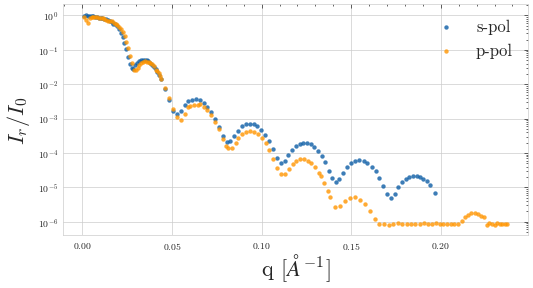

In [88]:
fig, ax = plt.subplots(figsize =( 6,3))

en = 250

s = znpc_mono[f"{en}"]["s"].iloc[6:]
p = znpc_mono[f"{en}"]["p"].iloc[6:]

q_s = models[en]["s"][:,0][q_range <= s.iloc[-1]["Q"]]
q_p = models[en]["p"][:,0][q_range <= p.iloc[-1]["Q"]]
s_model = models[en]["s"][:,1][q_range < s.iloc[-1]["Q"]]
p_model = models[en]["p"][:,1][q_range < p.iloc[-1]["Q"]]

# sns.lineplot(x = q_s, y = s_model, ax = ax, color = "k", linewidth = 1)
# sns.lineplot(x = q_p, y = p_model, ax = ax, color = "k", linewidth = 1)
s.plot(x = "Q", y = "Refl", ax = ax, kind = 'scatter', s = 10, color = "C0", alpha=.8, linewidth=0)
p.plot(x = "Q", y = "Refl", ax = ax, kind = 'scatter', s = 10, color = "C2", alpha=.8, linewidth=0)
ax.set_xlabel(r"q [$\AA^{-1}$]", labelpad = 0, fontsize = 16, fontweight = "bold")
ax.set_ylabel(r"$I_r / I_0$", fontsize = 16, fontweight = "bold")
ax.legend(["s-pol", "p-pol"], fontsize = 12)
ax.set(
    yscale = "log",
)

fig.savefig("fig4_250.svg", bbox_inches = "tight", dpi = 300, facecolor = "white")

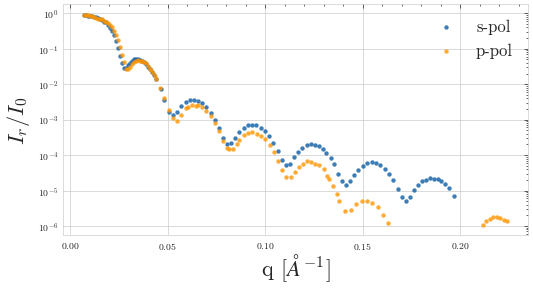

In [89]:
fig, ax = plt.subplots(figsize =( 6,3))

en = 250

s = znpc_mono[f"{en}"]["s"].iloc[6:]
_p = znpc_mono[f"{en}"]["p"].iloc[6:]
p = _p[_p["Refl"] > 1e-6]


q_s = models[en]["s"][:,0][q_range <= s.iloc[-1]["Q"]]
q_p = models[en]["p"][:,0][q_range <= p.iloc[-1]["Q"]]
s_model = models[en]["s"][:,1][q_range < s.iloc[-1]["Q"]]
p_model = models[en]["p"][:,1][q_range < p.iloc[-1]["Q"]]


s.plot(x = "Q", y = "Refl", ax = ax, kind = 'scatter', s = 10, color = "C0", alpha=.8, linewidth=0)
p.plot(x = "Q", y = "Refl", ax = ax, kind = 'scatter', s = 10, color = "C2", alpha=.8, linewidth=0)
# sns.lineplot(x = q_s, y = s_model, ax = ax, color = "k", linewidth = 1)
# sns.lineplot(x = q_p, y = p_model, ax = ax, color = "k", linewidth = 1)
ax.set_xlabel(r"q [$\AA^{-1}$]", labelpad = 0, fontsize = 16, fontweight = "bold")
ax.set_ylabel(r"$I_r / I_0$", fontsize = 16, fontweight = "bold")
ax.legend(["s-pol", "p-pol"], fontsize = 12)
ax.set(
    yscale = "log",
)

fig.savefig("fig4_250_remove.svg", bbox_inches = "tight", dpi = 300, facecolor = "white")

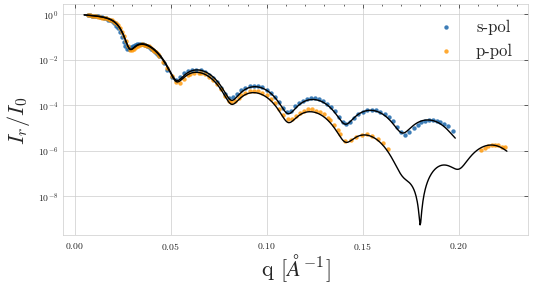

In [90]:
fig, ax = plt.subplots(figsize =( 6,3))

en = 250

s = znpc_mono[f"{en}"]["s"].iloc[6:]
_p = znpc_mono[f"{en}"]["p"].iloc[6:]
p = _p[_p["Refl"] > 1e-6]


q_s = models[en]["s"][:,0][q_range <= s.iloc[-1]["Q"]]
q_p = models[en]["p"][:,0][q_range <= p.iloc[-1]["Q"]]
s_model = models[en]["s"][:,1][q_range < s.iloc[-1]["Q"]]
p_model = models[en]["p"][:,1][q_range < p.iloc[-1]["Q"]]


s.plot(x = "Q", y = "Refl", ax = ax, kind = 'scatter', s = 10, color = "C0", alpha=.8, linewidth=0)
p.plot(x = "Q", y = "Refl", ax = ax, kind = 'scatter', s = 10, color = "C2", alpha=.8, linewidth=0)
sns.lineplot(x = q_s, y = s_model, ax = ax, color = "k", linewidth = 1)
sns.lineplot(x = q_p, y = p_model, ax = ax, color = "k", linewidth = 1)
ax.set_xlabel(r"q [$\AA^{-1}$]", labelpad = 0, fontsize = 16, fontweight = "bold")
ax.set_ylabel(r"$I_r / I_0$", fontsize = 16, fontweight = "bold")
ax.legend(["s-pol", "p-pol"], fontsize = 12)
ax.set(
    yscale = "log",
)

fig.savefig("fig4_250_fit.svg", bbox_inches = "tight", dpi = 300, facecolor = "white")